In [54]:
import sys
sys.path.append("..")
from copy import deepcopy

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
from hpl.utils.postprocessing import (
    find_experiments_directories, 
    load_data_assimilation_network, 
    load_hydra_config,
    dictconfig_to_dataframe,
)
from hpl.datamodule.DataLoader import L96InferenceDataset

In [151]:
base_dir = "/gpfs/work/zinchenk/120324_try_batch_norm/"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"

In [152]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [155]:
hyda_experiments = find_experiments_directories([base_dir])

In [156]:
def reconstruct_observations(dataset, assimilation_network, verbose=False):
    reconstractions = []
    iterator = tqdm(dataset) if verbose else dataset
    with torch.no_grad():
        for batch in iterator:
            reconstructed_state = assimilation_network.forward(batch)
            reconstractions.append(reconstructed_state)
    reconstractions = torch.stack(reconstractions, dim=-2).squeeze()
    return reconstractions

In [159]:
def main(hydra_experiment: str, device: str):
    assimilation_network = load_data_assimilation_network(hydra_experiment, device=device)
    config = load_hydra_config(hydra_experiment)
    results_frame = dictconfig_to_dataframe(config)
    results_frame.insert(0, "experiment_dir", hydra_experiment, False)
    
    torch.manual_seed(random_seed)
    pl.seed_everything(random_seed)
    dataset = L96InferenceDataset(
        ground_truth_data=test_simulations,
        additional_noise_std=config.datamodule.dataset.additional_noise_std,
        random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
        mask_even_locations=config.datamodule.dataset.mask_even_locations,
        input_window_extend=config.input_window_extend,
    )
    
    reconstructions = reconstruct_observations(dataset, assimilation_network)
    ground_truth = dataset.ground_truth[:, config.input_window_extend:-config.input_window_extend+1]
    squered_errors = (reconstructions - ground_truth)**2
    rmse_per_test_case = squered_errors.mean((-1, -2)).sqrt()
    
    results_frame.insert(0, "min_rmse", rmse_per_test_case.min().cpu().item(), False)
    results_frame.insert(0, "max_rmse", rmse_per_test_case.max().cpu().item(), False)
    results_frame.insert(0, "mean_rmse", rmse_per_test_case.mean().cpu().item(), False)
    results_frame.insert(0, "std_rmse", rmse_per_test_case.std().cpu().item(), False)
       
    return results_frame

In [161]:
results = []
for experiment in tqdm(hyda_experiments):
    res = main(experiment, device)
    results.append(res)






  0%|                                                                                                                                  | 0/42 [00:00<?, ?it/s]Global seed set to 2510





  2%|██▉                                                                                                                       | 1/42 [00:14<09:54, 14.50s/it]Global seed set to 2510





  5%|█████▊                                                                                                                    | 2/42 [00:28<09:33, 14.34s/it]Global seed set to 2510





  7%|████████▋                                                                                                                 | 3/42 [00:42<09:17, 14.29s/it]Global seed set to 2510





 10%|███████████▌                                                                                                              | 4/42 [00:57<09:01, 14.26s/it]Global seed set to 2510





 12%|██████████████▌                                        

In [164]:
df = pd.concat(results, ignore_index=True)

In [242]:
df.to_pickle("120324_try_batch_norm")

In [243]:
ls

120324_try_batch_norm  data_assimilation.ipynb
2024-13-02-15-24/      data_assimilation_example.ipynb
alpha_plots.png        evaluate_data_assimilation_network.ipynb
daexample.ipynb        tmp/


In [180]:
df.rollout_length.unique()

array([ 1, 25, 10])

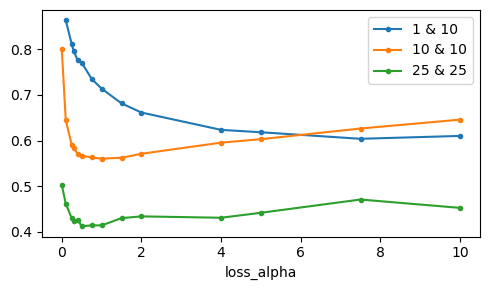

In [216]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

df[(df.rollout_length == 1) & (df.loss_alpha > 0)].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="1 & 10",
    marker="o",
    ms=3,
    ax=ax, 
)
df[df.rollout_length == 10].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="10 & 10", 
    marker="o",
    ms=3,
    ax=ax,
)
df[df.rollout_length == 25].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="25 & 25", 
    marker="o",
    ms=3,
    ax=ax,
)

plt.tight_layout()
plt.savefig("alpha_plots.png", dpi=300)

In [220]:
def find_best_model(df: pd.DataFrame):
    return df[df.mean_rmse == df.mean_rmse.min()]

In [225]:
find_best_model(df[df.rollout_length == 25])["experiment_dir"].item()

'/gpfs/work/zinchenk/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5'